In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

In [2]:
cd ../

/home/michael/Dropbox/PhD/Python/unified_model


In [3]:
# Mechanical system imports
from unified_model.mechanical_system.damper.damper import Damper
from unified_model.mechanical_system.input_excitation.accelerometer import AccelerometerInput
from unified_model.mechanical_system.spring.magnetic_spring import MagneticSpring
from unified_model.mechanical_system.magnet_assembly.magnet_assembly import MagnetAssembly
from unified_model.mechanical_system.mechanical_system import MechanicalSystem

from unified_model.electrical_system.flux.utils import FluxDatabase
from unified_model.electrical_system.flux.model import flux_interpolate, flux_univariate_spline
from unified_model.electrical_system.electrical_system import ElectricalSystem
from unified_model.electrical_system.coupling import ConstantCoupling
from unified_model.electrical_system.load import SimpleLoad

import matplotlib.pyplot as plt

In [4]:
spring = MagneticSpring(fea_data_file = 'unified_model/mechanical_system/spring/data/10x10alt.csv', model='savgol_smoothing', model_type='interp')

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [5]:
magnet_assembly = MagnetAssembly(n_magnet=1,
                                h_magnet=10,
                                h_spacer=0,
                                dia_magnet=10,
                                dia_spacer=10)

In [6]:
damper = Damper(model='constant', model_kwargs={'damping_coefficient' : 0.030})

In [7]:
accelerometer = AccelerometerInput('unified_model/mechanical_system/input_excitation/data/2018-10-04/log_02.csv',
                                  accel_column='z_G',
                                  time_column='time(ms)',
                                  time_unit='ms')

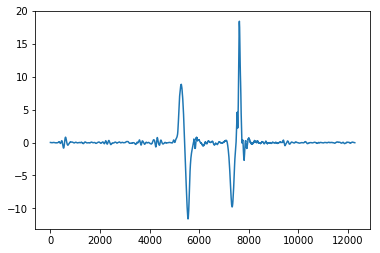

In [8]:
accelerometer.acceleration_df['z_G'].plot()

In [9]:
%load_ext line_profiler

In [69]:
mech_system = MechanicalSystem()

mech_system.set_model('unified_ode_coupled')
mech_system.set_damper(damper)
mech_system.set_magnet_assembly(magnet_assembly)
mech_system.set_magnetic_spring(spring)
mech_system.set_input(accelerometer)

# Electrical system
fdb = FluxDatabase('../Research/fea-flux-curves-numr[1-20-600]-numz[1-20-600]-wdiam[0.127]-2018-03-24[10.45.22].csv', fixed_velocity=0.35)
flux_model = flux_univariate_spline(fdb.z, fdb.query(winding_num_z='21', winding_num_r='101'), coil_center=0.06, mf=magnet_assembly.get_height())
load_model = SimpleLoad(R=1)
coupling = ConstantCoupling(c=0.005)
electrical_system = ElectricalSystem(flux_model=flux_model,
                                    load_model=load_model,
                                    precompute_gradient=True)
mech_system.attach_electrical_system(electrical_system=electrical_system,
                                     coupling=coupling)

In [70]:
mech_system.set_initial_conditions([0, 0, 0.04, 0, 0])

In [71]:
from unified_model.model import unified_ode_coupled

In [72]:
from scipy.interpolate import UnivariateSpline
from numba import jit

In [77]:
%lprun -f unified_ode_coupled mech_system.solve(t_start=2, t_end=6, t_max_step=0.01)

Timer unit: 1e-06 s

Total time: 5.93568 s
File: /home/michael/Dropbox/PhD/Python/unified_model/unified_model/model.py
Function: unified_ode_coupled at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def unified_ode_coupled(t, y, kwargs):
     6                                               """
     7                                               A coupled unified electro-mechanical model.
     8                                               """
     9                                           
    10     57218      43576.0      0.8      0.7      spring = kwargs['spring']
    11     57218      25699.0      0.4      0.4      damper = kwargs['damper']
    12     57218      25012.0      0.4      0.4      mechanical_input = kwargs['input']
    13     57218      23505.0      0.4      0.4      magnet_assembly = kwargs['magnet_assembly']
    14     57218      23301.0      0.4      0.4      coupling = kwargs['coupling']
  

In [78]:
output = mech_system.get_output(t='t',
                                magnet_assembly_relative_displacement='x3-x1')

In [79]:
output.head()

,t,magnet_assembly_relative_displacement
0,2.000000,0.040000
1,2.000947,0.040000
2,2.003098,0.040005
3,2.007336,0.040027
4,2.013795,0.040093


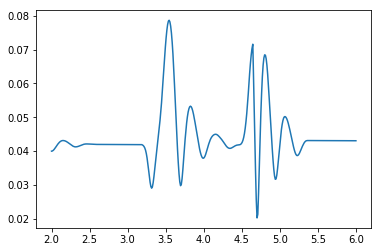

In [80]:
plt.plot(output['t'], output['magnet_assembly_relative_displacement'])

# Dynamic model investigation

In [10]:
from unified_model.model import unified_ode_coupled

In [4]:
# flux database
fdb = FluxDatabase('../Research/fea-flux-curves-numr[1-20-600]-numz[1-20-600]-wdiam[0.127]-2018-03-24[10.45.22].csv', fixed_velocity=0.35)

In [18]:
phi = fdb.query(winding_num_z='401', winding_num_r='101')
z = fdb.z

# Free-fall
We expect to see "braking" of the magnet assembly as it moves through the coil

In [10]:
from unified_model.model import unified_ode_coupled

In [11]:
import copy
accelerometer_freefall = copy.deepcopy(accelerometer)
no_spring = copy.deepcopy(spring)

In [24]:
def dummy_spring(*args, **kwargs):
    return 0.0

In [25]:
no_spring.model = dummy_spring

In [26]:
accelerometer_freefall.acceleration_df['z_G'] = 0

In [27]:
from unified_model.electrical_system.coupling import ConstantCoupling
from unified_model.electrical_system.electrical_system import ElectricalSystem
from unified_model.electrical_system.load import SimpleLoad
from unified_model.electrical_system.flux.model import flux_interpolate
from unified_model.electrical_system.flux.utils import FluxDatabase

In [28]:
fdb = FluxDatabase('../Research/fea-flux-curves-numr[1-20-600]-numz[1-20-600]-wdiam[0.127]-2018-03-24[10.45.22].csv', fixed_velocity=0.35)

In [29]:
load = SimpleLoad(R=1)

phi = fdb.query(winding_num_z='21', winding_num_r='101')
z = fdb.z
flux_model = flux_interpolate(z, phi, coil_center=0.06, mf=magnet_assembly.get_height())


In [30]:
es = ElectricalSystem(flux_model=flux_model, load_model=load)

In [31]:
kwargs = {'spring' : no_spring,
         'damper': damper,
         'input' : accelerometer_freefall,
         'magnet_assembly': magnet_assembly,
         'electrical_system': es,
         'coupling': ConstantCoupling(0.05)}

In [32]:
psoln = solve_ivp(fun=lambda t, y: unified_ode_coupled(t, y, kwargs),
                  t_span=(0,0.5),
                 y0=[0,0,0.2,0, 0],
                 max_step=0.001)

In [33]:
x1 = psoln.y[0, :]  # Tube displacement
x2 = psoln.y[1, :]  # Tube velocity
x3 = psoln.y[2, :]  # Magnet assembly displacement
x4 = psoln.y[3, :]  # Magnet assembly velocity
x5 = psoln.y[4, :]  # Flux
t = psoln.t


x_relative_displacement = x3 - x1
x_relative_velocity = x4 - x2

Text(0.5, 1.0, 'Displacement')

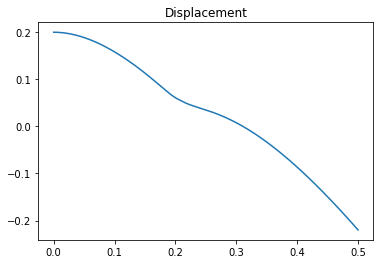

In [34]:
import matplotlib.pyplot as plt
plt.plot(t, x_relative_displacement)  # displacement
plt.title('Displacement')

Text(0.5, 1.0, 'Relative velocity')

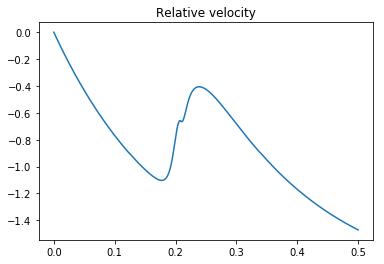

In [35]:
plt.plot(t, x_relative_velocity)
plt.title('Relative velocity')

Text(0.5, 1.0, 'EMF')

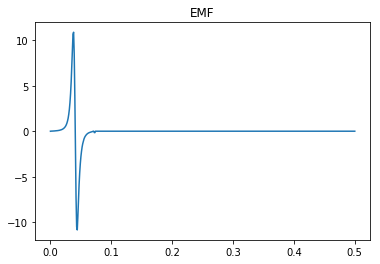

In [36]:
plt.plot(psoln.t, np.gradient(x5)/np.gradient(psoln.t))
plt.title('EMF')

# Dynamic case

In [37]:
kwargs = {'spring' : spring,  # Changed back to magnetic spring
         'damper': damper,
         'input' : accelerometer,  # Back to input force
         'magnet_assembly': magnet_assembly,
         'electrical_system': es,
         'coupling': ConstantCoupling(c=0.005)}

In [38]:
psoln = solve_ivp(fun=lambda t, y: unified_ode_coupled(t, y, kwargs),
                  t_span=(2,8),
                 y0=[0,0,0.04,0, 0],
                 max_step=0.001)

In [39]:
x1 = psoln.y[0, :]  # Tube displacement
x2 = psoln.y[1, :]  # Tube velocity
x3 = psoln.y[2, :]  # Magnet assembly displacement
x4 = psoln.y[3, :]  # Magnet assembly velocity
x5 = psoln.y[4, :]  # Flux
t = psoln.t


x_relative_displacement = x3 - x1
x_relative_velocity = x4 - x2

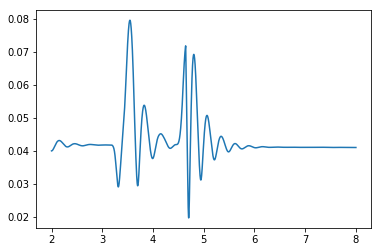

In [40]:
import matplotlib.pyplot as plt
plt.plot(t, x3-x1)  # displacement

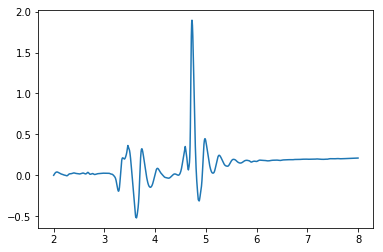

In [41]:
plt.plot(t, x_relative_velocity)

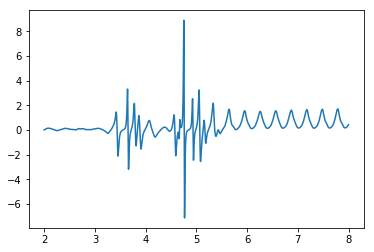

In [69]:
plt.plot(psoln.t, np.gradient(x5)/np.gradient(psoln.t))